In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import gzip
import sys
import struct
import urllib.request

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )

In [4]:
data = np.load('mnist.npz')

print("Training data (X):", data['train_x'].shape, data['train_x'].dtype)
print("Training data (Y):", data['train_y'].shape, data['train_y'].dtype)
print("Test data (X):", data['test_x'].shape, data['test_x'].dtype)
print("Test data (Y):", data['test_y'].shape, data['test_y'].dtype)

Training data (X): (60000, 28, 28) float32
Training data (Y): (60000,) uint8
Test data (X): (10000, 28, 28) float32
Test data (Y): (10000,) uint8


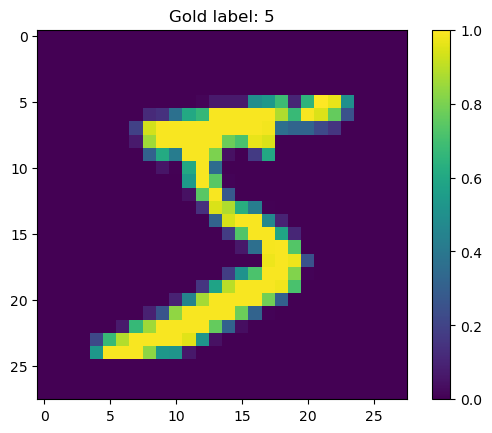

In [5]:
i = 0
x = data['train_x'][i]
y = data['train_y'][i]

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.set_title('Gold label: {}'.format(y))
im = ax.imshow(x)
fig.colorbar(im)
plt.show()

In [6]:
x[7][8]

0.93333334

In [7]:
def images_to_vectors(X):
    X = np.reshape(X, (len(X), -1))         # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]        # Append 1: (N x 784) -> (N x 785)

X_train = images_to_vectors(data['train_x'])
X_test = images_to_vectors(data['test_x'])

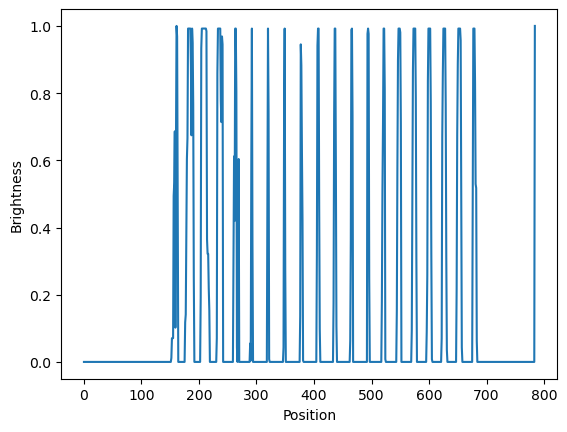

In [8]:
x = X_train[i]

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.plot(range(len(x)), x)
ax.set_xlabel('Position')
ax.set_ylabel('Brightness')
plt.show()

In [9]:
x[204]

0.9333333373069763

In [10]:
def softmax(a):
    ea = np.exp(a)
    return ea / ea.sum()

a = np.array([0.1, -0.2, 0.3, -0.4, 0.5])
softmax(a)

array([0.19760595, 0.14639009, 0.24135645, 0.11985407, 0.29479344])

/var/folders/pl/l83vr0j523j0hp3dngvsrhqc0000gn/T/ipykernel_74831/3115073462.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


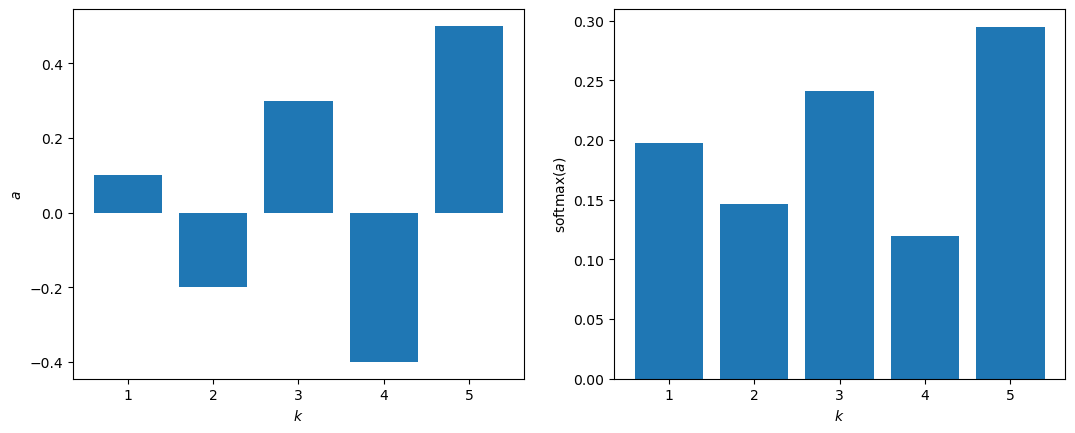

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
ax1.bar(range(1, 6), a)
ax1.set_xlabel('$k$')
ax1.set_ylabel('$a$')
ax2.bar(range(1, 6), softmax(a))
ax2.set_xlabel('$k$')
ax2.set_ylabel(r'${\rm softmax}(a)$')
fig.show()

In [12]:
a = np.array([1000, 0])
softmax(a)

/var/folders/pl/l83vr0j523j0hp3dngvsrhqc0000gn/T/ipykernel_74831/1076038691.py:2: RuntimeWarning: overflow encountered in exp
  ea = np.exp(a)
/var/folders/pl/l83vr0j523j0hp3dngvsrhqc0000gn/T/ipykernel_74831/1076038691.py:3: RuntimeWarning: invalid value encountered in divide
  return ea / ea.sum()


array([nan,  0.])

In [13]:
def softmax(a):
    ea = np.exp(a - np.max(a))
    return ea / ea.sum()

a = np.array([1000, 0])
softmax(a)

array([1., 0.])

In [15]:
import numpy as np
from sklearn.linear_model import SGDClassifier

def image_to_vector(X):
    return np.reshape(X, (len(X), -1))  # Flatten: (N x 28 x 28) -> (N x 784)

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])       # (60000 x 784) (no bias term)
Ytrain = data['train_y']                        # (60000) (not one-hot encoding)
Xtest = image_to_vector(data['test_x'])         # (10000 x 784) (no bias term)
Ytest = data['test_y']                          # (10000) (not one-hot encoding)

model = SGDClassifier(loss='log')
model.fit(Xtrain, Ytrain)

/Users/kawanodaiya/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


SGDClassifier(loss='log')

In [16]:
model.predict_proba(Xtest[0:1])

array([[4.24490931e-05, 3.25555482e-10, 6.85107722e-04, 1.56010396e-02,
        1.04418122e-05, 2.05691869e-04, 3.26102765e-08, 9.82238519e-01,
        6.16981071e-05, 1.15502004e-03]])

In [17]:
model.score(Xtest, Ytest)

0.9116

In [18]:
from sklearn.metrics import confusion_matrix
Ytest_pred = model.predict(Xtest)
confusion_matrix(Ytest, Ytest_pred)

array([[ 957,    0,    1,    2,    1,    4,    9,    2,    1,    3],
       [   0, 1109,    2,    2,    1,    1,    5,    1,   14,    0],
       [   8,    7,  906,   24,   12,    3,   14,   12,   43,    3],
       [   6,    2,   18,  932,    2,    6,    5,   10,   17,   12],
       [   1,    1,    3,    1,  930,    0,    9,    1,    6,   30],
       [  11,    3,    2,   79,   17,  698,   24,    7,   40,   11],
       [   8,    3,    6,    3,    7,    9,  919,    1,    2,    0],
       [   3,   10,   23,    6,   10,    1,    1,  921,    3,   50],
       [   9,   13,    7,   27,   19,   19,   12,    8,  845,   15],
       [   6,    7,    1,   14,   47,    6,    1,   18,   10,  899]])

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
Ytest_pred = model.predict(Xtest)

In [20]:
precision_score(Ytest, Ytest_pred, average=None)
recall_score(Ytest, Ytest_pred, average=None)
f1_score(Ytest, Ytest_pred, average=None)

array([0.96229261, 0.96855895, 0.90554723, 0.88761905, 0.91715976,
       0.85173887, 0.93919264, 0.91687407, 0.86445013, 0.88484252])

In [21]:
precision_score(Ytest, Ytest_pred, average='macro')　# マクロ平均適合率

0.9121084671966667

In [22]:
recall_score(Ytest, Ytest_pred, average='macro') # 再現率

0.9097602653595356

In [23]:
f1_score(Ytest, Ytest_pred, average='macro') # F1スコア

0.9098275819858446